<a href="https://colab.research.google.com/github/PandaPowell/ECG_DDA/blob/master/neuropathy_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning to classify prevalent diabetic neuropathy from ECGs using a computer vision model

## 1. Setup

### Install and import packages

In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import os
from google.colab import drive



### Mount Google Drive and sync to Git repository

In [5]:
## Mount google drive
drive.mount('/content/ecg_data')

# Clone git repo (uncomment if not already cloned)
%cd '/content/ecg_data/MyDrive/ecg_ai/'
#! git clone https://github.com/PandaPowell/ECG_DDA

Mounted at /content/ecg_data
/content/ecg_data/MyDrive/ecg_ai


In [ ]:
# Pull updates:
%cd '/content/ecg_data/MyDrive/ecg_ai/ECG_DDA'
! git pull

/content/ecg_data/MyDrive/ecg_ai/ECG_DDA
Already up to date.


## 2. Training ResNet models
 * Quick models:
  * ResNet18, 5 epochs
    * On training/validation split by source dataset
    * On random 80%/20% training/validation split by individual
 * Further trained models: ResNet18, 20 epochs
      * On training/validation split by source dataset
      * On random 80%/20% training/validation split by individual

All models trained with default settings:
 * item_tfms = RandomResizedCrop(200, min_scale=0.5)
 * batch_tfms = aug_transforms()

#### Count number of 10-second ECG snippet images: 15,528

In [6]:
ecg_root = '/content/ecg_data/MyDrive/ecg_ai/ECG_DDA/ecg_img/'


img_lst = [val for sublist in [[os.path.join(i[0], j) for j in i[2] if j.endswith('.png')] for i in os.walk(ecg_root)] for val in sublist]


len(img_lst)

15528

#### Load data into fastai DataLoaders

In [22]:
ecgs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(200, min_scale=0.5),
    batch_tfms=aug_transforms())

In [23]:
dls_sourcesplit = ecgs.dataloaders(ecg_root)


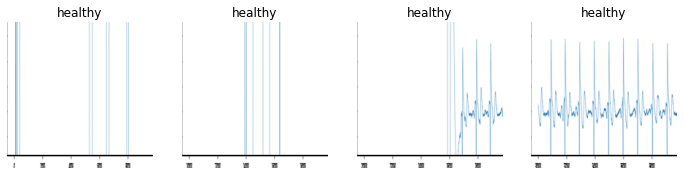

In [24]:
dls_sourcesplit.valid.show_batch(max_n=4, nrows=1)


#### Train and evaluate the quick ResNet18 models (5 epochs)

##### First up: The training/validation split by source dataset:

In [27]:
learn_resnet_sourcesplit_5 = vision_learner(dls_sourcesplit, resnet18, metrics=error_rate)
learn_resnet_sourcesplit_5.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.730148,0.806576,0.453846,1:33:10


epoch,train_loss,valid_loss,error_rate,time
0,0.422503,0.853631,0.469231,01:57
1,0.249780,1.269185,0.525874,01:56
2,0.184208,1.751952,0.490909,01:57
3,0.127452,2.189670,0.490210,01:56
4,0.112049,2.286098,0.486014,01:57


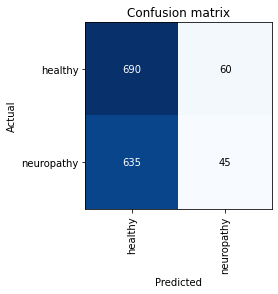

In [29]:
interp = ClassificationInterpretation.from_learner(learn_resnet_sourcesplit_5)
interp.plot_confusion_matrix()

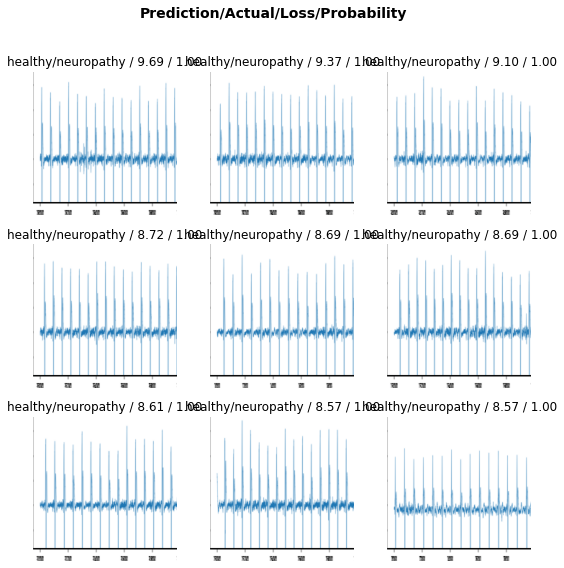

In [31]:
interp.plot_top_losses(9, nrows=3)

* Export model

In [37]:
learn_resnet_sourcesplit_5.export(fname = 'learn_resnet_sourcesplit_5.pkl')

##### Next: The random 80/20-split by individual:

In [40]:
rand_ecg_root = '/content/ecg_data/MyDrive/ecg_ai/ECG_DDA/ecg_img_randomsplit/'
ecgs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(200, min_scale=0.5),
    batch_tfms=aug_transforms())
dls_randomsplit = ecgs.dataloaders(rand_ecg_root)

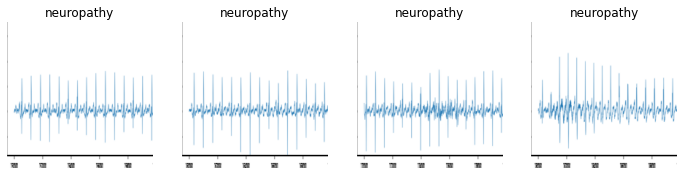

In [41]:
dls_randomsplit.valid.show_batch(max_n=4, nrows=1)

In [42]:
learn_resnet_randomsplit_5 = vision_learner(dls_randomsplit, resnet18, metrics=error_rate)
learn_resnet_randomsplit_5.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.826357,1.053185,0.510332,57:34


epoch,train_loss,valid_loss,error_rate,time
0,0.435248,0.974244,0.486224,01:59
1,0.246918,0.803278,0.448341,01:59
2,0.172086,0.907746,0.375704,02:00
3,0.127733,1.016446,0.353475,01:59
4,0.096706,1.153835,0.366312,01:59


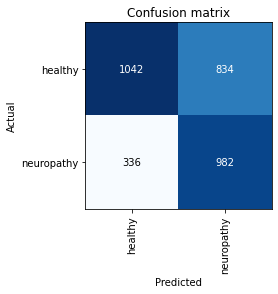

In [43]:
rand_interp = ClassificationInterpretation.from_learner(learn_resnet_randomsplit_5)
rand_interp.plot_confusion_matrix()

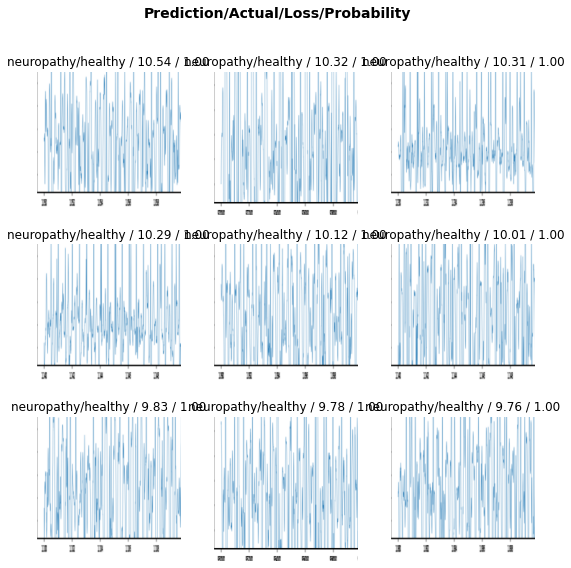

In [44]:
rand_interp.plot_top_losses(9, nrows=3)

* Export model

In [45]:
learn_resnet_randomsplit_5.export(fname = 'learn_resnet_randomsplit_5.pkl')

### Create web app for questionable clinical decision support
Check it out [here!](https://mybinder.org/v2/gh/Aastedet/ecg_neuropathy_app/HEAD?labpath=%2Fvoila%2Frender%2Fecg_neuropathy_app.ipynb)

### Keep training models for a total of 20 epochs

In [46]:
learn_resnet_sourcesplit_5.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,0.118536,2.765992,0.488811,01:57


epoch,train_loss,valid_loss,error_rate,time
0,0.104333,2.636469,0.485315,01:59
1,0.108523,2.375553,0.487413,01:58
2,0.117802,2.055140,0.474825,01:59
3,0.120537,1.894893,0.475524,01:59
4,0.106161,2.407863,0.483217,01:59
5,0.099533,2.952063,0.488112,01:59
6,0.090062,3.314951,0.476224,02:00
7,0.081615,2.716720,0.474126,02:00
8,0.064096,2.975893,0.478322,02:00
9,0.048545,2.464981,0.481818,01:59


In [47]:
learn_resnet_randomsplit_5.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,0.100344,1.331789,0.370695,01:57


epoch,train_loss,valid_loss,error_rate,time
0,0.101036,1.292915,0.407952,02:00
1,0.106690,1.234140,0.408579,01:58
2,0.111303,1.243578,0.360676,01:59
3,0.110841,1.193323,0.412336,01:59
4,0.095792,1.782268,0.375391,02:00
5,0.090895,1.621686,0.373513,01:59
6,0.070983,1.384549,0.349405,01:59
7,0.067734,1.211638,0.367251,02:00
8,0.050573,1.407846,0.385097,01:59
9,0.048562,1.528895,0.364120,01:59


### Leads to overfitting!